# 🖼️ -> 🖼️ Transferencia de Estilo Neuronal en PyTorch




## Transferencia de estilo neuronal (Scratch)
Aplicar la técnica de transferencia de estilo neuronal (TEN) y TEN con control espacial para combinar una imagen de contenido con una imagen de estilo.

**Imagen de contenido:**
[![Xolo Des](https://www.gaceta.unam.mx/wp-content/uploads/2021/08/xolodes.jpg)](https://www.gaceta.unam.mx/wp-content/uploads/2021/08/xolodes.jpg)

**Imagen de estilo:**
[![Mone](https://mymodernmet.com/wp/wp-content/uploads/2022/04/Henri-Edmond-Cross-puntillismo.jpeg)](https://mymodernmet.com/wp/wp-content/uploads/2022/04/Henri-Edmond-Cross-puntillismo.jpeg)



### Carga de imágenes

In [ ]:
import torch.nn.functional as F
import os
from PIL import Image
import requests
from io import BytesIO
import torchvision.transforms as transforms
import torch
from torchvision import models
import torch.optim as optim
import imageio
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_image(url, max_size=512, shape=None):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).convert('RGB')

    if shape:
        size = shape
    else:
        size = max_size if max(image.size) > max_size else max(image.size)

    in_transform = transforms.Compose([
        transforms.Resize(size if isinstance(size, tuple) else (size, size)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x[:3, :, :]),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))
    ])

    image = in_transform(image).unsqueeze(0)
    return image


content_url = "https://www.gaceta.unam.mx/wp-content/uploads/2021/08/xolodes.jpg"
style_url = "https://mymodernmet.com/wp/wp-content/uploads/2022/04/Henri-Edmond-Cross-puntillismo.jpeg"

content = load_image(content_url).to(device)
style = load_image(style_url, shape=content.shape[-2:]).to(device)



### Arquitectura base (VGG19)

Usamos la red preentrenada `VGG19` de PyTorch.



In [ ]:
vgg = models.vgg19(pretrained=True).features.to(device).eval()

# Congelamos los pesos
for param in vgg.parameters():
    param.requires_grad_(False)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 89.4MB/s]




### Selección de capas de contenido y estilo


In [ ]:
def get_features(image, model, layers=None):
    if layers is None:
        layers = {
            '0': 'conv1_1',
            '5': 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '21': 'conv4_2',  # contenido
            '28': 'conv5_1'
        }

    features = {}
    x = image.to(device)
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features

content_features = get_features(content, vgg)
style_features = get_features(style, vgg)


In [ ]:
for i in content_features.keys():
  print(f"El bloque {i} tiene {content_features[i].shape}")

El bloque conv1_1 tiene torch.Size([1, 64, 512, 512])
El bloque conv2_1 tiene torch.Size([1, 128, 256, 256])
El bloque conv3_1 tiene torch.Size([1, 256, 128, 128])
El bloque conv4_1 tiene torch.Size([1, 512, 64, 64])
El bloque conv4_2 tiene torch.Size([1, 512, 64, 64])
El bloque conv5_1 tiene torch.Size([1, 512, 32, 32])



### Cálculo del estilo con matrices de Gram



In [ ]:
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram


### Generación de la imagen combinada



In [ ]:
target = content.clone().detach().requires_grad_(True)


Definimos pesos para cada capa de estilo:





In [ ]:
style_weights = {
    'conv1_1': 1.0,
    'conv2_1': 0.75,
    'conv3_1': 0.2,
    'conv4_1': 0.2,
    'conv5_1': 0.2
}

content_weight = 1e4  # α
style_weight = 1e2    # β

✅ (Extra) Mostrar las matrices de Gram (estilo) y activaciones (contenido)

activaciones del contenido de la última capa

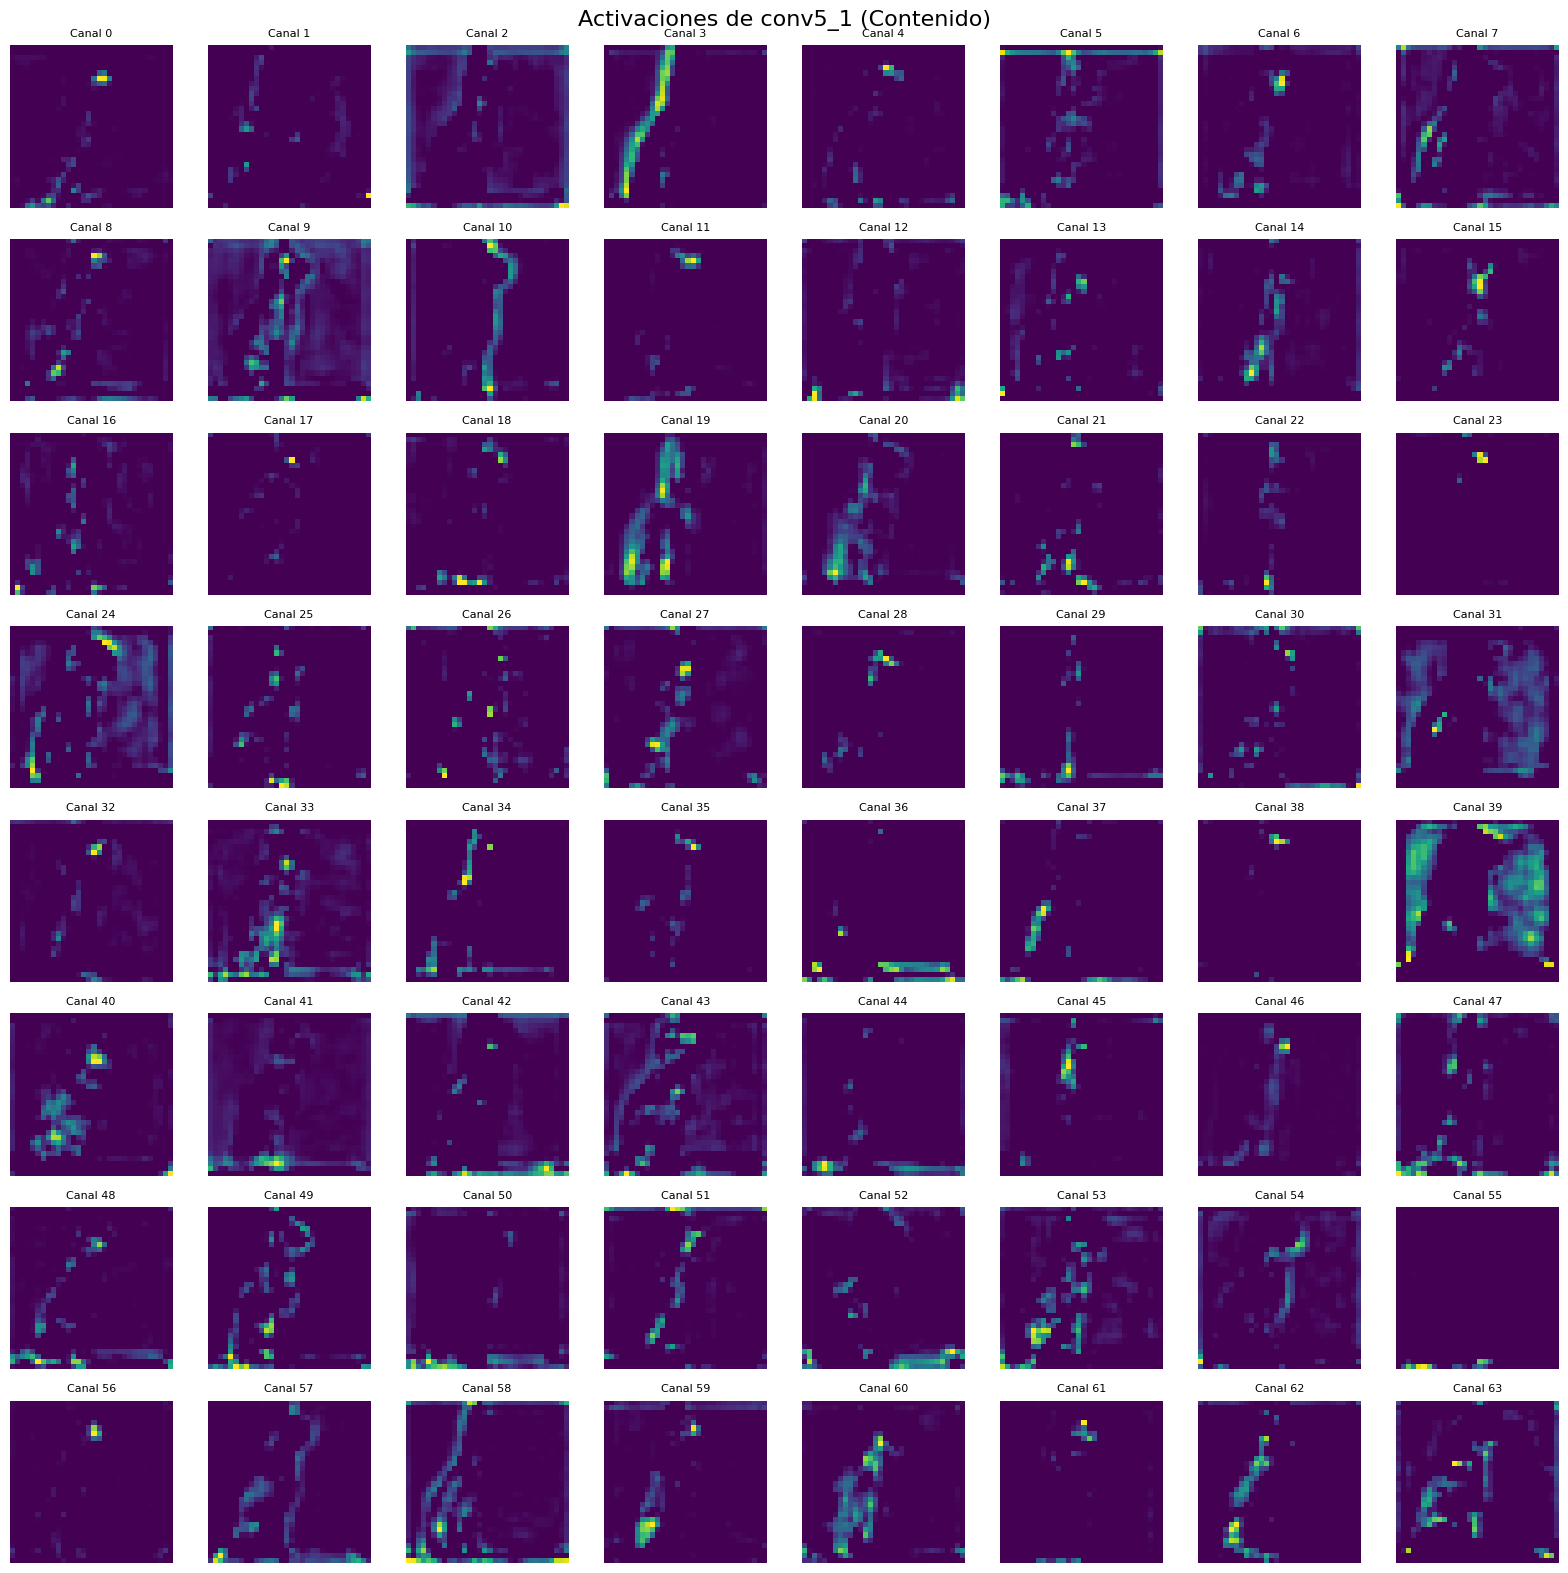

In [ ]:
def plot_feature_maps(tensor, max_maps=64, cols=8, title=''):
    """
    Muestra hasta `max_maps` canales de un tensor con shape (1, C, H, W)
    """
    tensor = tensor.detach().cpu().squeeze(0)  # (C, H, W)
    channels = tensor.shape[0]
    maps_to_show = min(channels, max_maps)

    rows = (maps_to_show + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    fig.suptitle(title, fontsize=16)

    for i in range(rows * cols):
        ax = axes[i // cols, i % cols]
        if i < maps_to_show:
            fmap = tensor[i]
            fmap = (fmap - fmap.min()) / (fmap.max() - fmap.min() + 1e-5)  # Normaliza
            ax.imshow(fmap.numpy(), cmap='viridis')
            ax.set_title(f"Canal {i}", fontsize=8)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Asegúrate de tener esto en tu entorno antes de llamar:
# content_features = get_features(content, vgg)

# Visualiza las activaciones de conv5_1
plot_feature_maps(content_features['conv5_1'], max_maps=64, cols=8, title='Activaciones de conv5_1 (Contenido)')

Matriz Gram del estilo

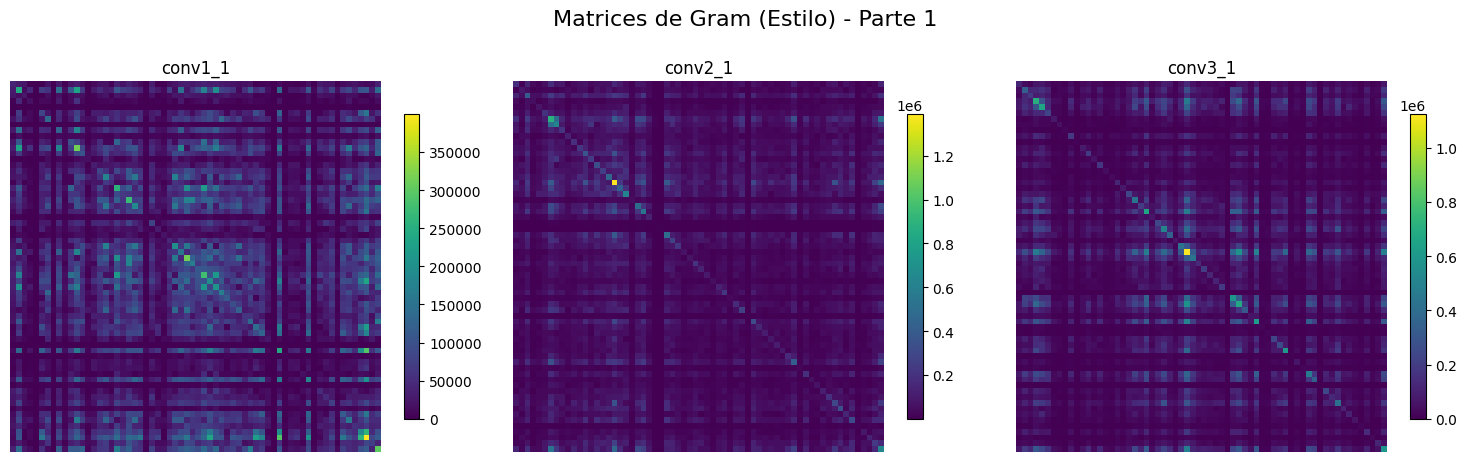

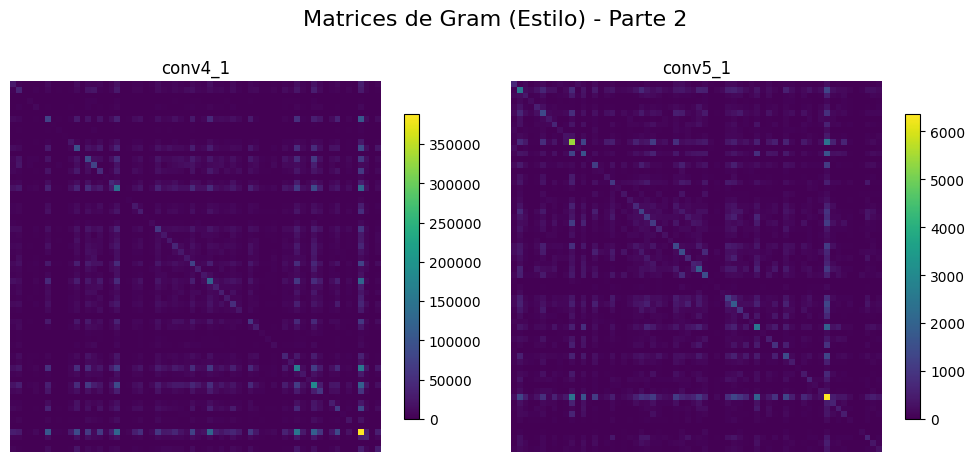

In [ ]:
def show_multiple_gram_matrices(style_features, layers, title):
    fig, axes = plt.subplots(1, len(layers), figsize=(5 * len(layers), 5))
    fig.suptitle(title, fontsize=16)

    for i, layer in enumerate(layers):
        gram = gram_matrix(style_features[layer]).detach().cpu()
        if gram.shape[0] > 64:
            gram = gram[:64, :64]  # Recorta si es muy grande

        ax = axes[i]
        im = ax.imshow(gram, cmap='viridis')
        ax.set_title(layer)
        ax.axis("off")
        fig.colorbar(im, ax=ax, shrink=0.7)

    plt.tight_layout()
    plt.show()

# Mostrar 3 primeras matrices
show_multiple_gram_matrices(style_features,
                            ['conv1_1', 'conv2_1', 'conv3_1'],
                            'Matrices de Gram (Estilo) - Parte 1')

# Mostrar 2 restantes
show_multiple_gram_matrices(style_features,
                            ['conv4_1', 'conv5_1'],
                            'Matrices de Gram (Estilo) - Parte 2')


### Ciclo de optimización



In [ ]:
# Función para desnormalizar imagen
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

# Función para visualizar y guardar gradiente
def save_gradient_image(grad_tensor, filename):
    grad = grad_tensor.clone().detach().squeeze(0).cpu()
    grad = grad.permute(1, 2, 0)  # (H, W, 3)
    grad = grad - grad.min()
    grad = grad / grad.max()
    grad_np = (grad.numpy() * 255).astype('uint8')
    Image.fromarray(grad_np).save(filename)

# Crear carpetas
os.makedirs("results", exist_ok=True)
os.makedirs("grads", exist_ok=True)

# Inicialización
frames = []
grad_frames = []
optimizer = optim.Adam([target], lr=0.003)
steps = 4000

for i in range(steps):
    target_features = get_features(target, vgg)

    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)

    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = gram_matrix(style_features[layer])
        layer_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)
        style_loss += layer_loss / (target_feature.shape[1] ** 2)

    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    total_loss.backward()

    if i % 100 == 0:
        print(f"Step {i}, Total loss: {total_loss.item():.4f}")

        # === Guardar imagen generada ===
        image = target.clone().detach().squeeze()
        image = image.cpu()
        image = denormalize(image).clamp(0, 1)
        image = image.permute(1, 2, 0).numpy()
        img_filename = f"results/frame_{i:03d}.png"
        Image.fromarray((image * 255).astype('uint8')).save(img_filename)
        frames.append(img_filename)

        # === Guardar gradiente ===
        grad_filename = f"grads/grad_{i:03d}.png"
        save_gradient_image(target.grad, grad_filename)
        grad_frames.append(grad_filename)

    optimizer.step()

# Crear GIFs
images = [imageio.imread(f) for f in frames]
imageio.mimsave('style_transfer.gif', images, fps=5)

grad_images = [imageio.imread(f) for f in grad_frames]
imageio.mimsave('gradients.gif', grad_images, fps=5)

print("GIFs guardados como 'style_transfer.gif' y 'gradients.gif'")

Step 0, Total loss: 72650096.0000
Step 100, Total loss: 30857574.0000
Step 200, Total loss: 18528002.0000
Step 300, Total loss: 12894356.0000
Step 400, Total loss: 9466493.0000
Step 500, Total loss: 7175968.5000
Step 600, Total loss: 5574048.0000
Step 700, Total loss: 4418734.0000
Step 800, Total loss: 3568175.7500
Step 900, Total loss: 2934700.5000
Step 1000, Total loss: 2457509.7500
Step 1100, Total loss: 2092242.8750
Step 1200, Total loss: 1807689.6250
Step 1300, Total loss: 1581287.1250
Step 1400, Total loss: 1397190.6250
Step 1500, Total loss: 1245090.3750
Step 1600, Total loss: 1117349.6250
Step 1700, Total loss: 1008927.0625
Step 1800, Total loss: 915901.8750
Step 1900, Total loss: 835333.0625
Step 2000, Total loss: 764999.8125
Step 2100, Total loss: 703097.3750
Step 2200, Total loss: 648225.9375
Step 2300, Total loss: 599257.3750
Step 2400, Total loss: 555263.9375
Step 2500, Total loss: 515645.9062
Step 2600, Total loss: 479883.0938
Step 2700, Total loss: 447410.6875
Step 2800,

<ipython-input-11-69ab047359d7>:64: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(f) for f in frames]
<ipython-input-11-69ab047359d7>:67: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  grad_images = [imageio.imread(f) for f in grad_frames]


GIFs guardados como 'style_transfer.gif' y 'gradients.gif'



### 🖼️ Visualización del resultado




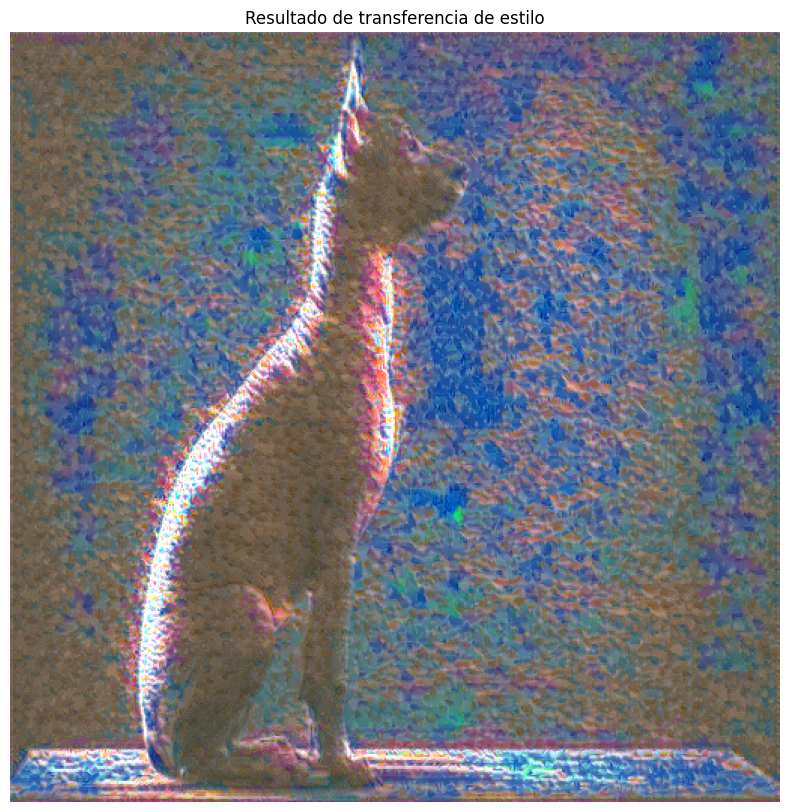

In [ ]:
def im_convert(tensor):
    image = tensor.clone().detach().cpu().squeeze(0)
    image = image * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    image = image + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    image = image.clamp(0, 1)
    return image

plt.figure(figsize=(10, 10))
plt.imshow(im_convert(target).permute(1, 2, 0).clamp(0, 1).numpy())
plt.axis('off')
plt.title('Resultado de transferencia de estilo')
plt.show()